# Imports
Run this block first to import all necessary libraries.

In [1]:
from functools import partial
import numpy as np
import pandas as pd
import torch
import pickle
import plotly.graph_objects as go
from IPython.core.display_functions import clear_output
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaModel
from Models_Native.utils.Datasets import TwitterDataset
from Models_Native.utils.Functions import train_loop, self_explain_collate_batch, eval_loop, load_model, \
    set_up_deterministic_environment, stratified_target_statement_split
from Models_Native.utils.SelfExplainModels import ExplainableModel

# Paths, Variables and Setup
Update paths to point to the correct files if necessary, update variables, and run the setup code blocks.

In [2]:
# Globals
TRAIN_SET_PATH = './data/dataset_splits/train.csv'
VAL_SET_PATH = './data/dataset_splits/val.csv'
TEST_SET_PATH = './data/dataset_splits/test.csv'
DATASET_FULL_PATH = './data/dataset.csv'
FOLDS_TEST_PATH = './data/dataset_splits/holdout_training/test{}.csv'
SEMANTIC_EVAL_PATH = './data/model_eval/semantic_eval/{}'
LLM_DATA_PATH = './data/model_eval/LLM/{}'
MODEL_CHECKPOINT_PATH = './models/selfexplain/{}-fold-{}-best.pt'

In [3]:
# Variables
RANDOM_SEED=42
BATCH_SIZE=16
LR=2e-5
MAX_EPOCHS=30

In [4]:
# Setup: CUDA Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# Setup: Class Mapping
class_mapping = {
    "decreased": 0,
    "neutral": 1,
    "increased": 2
}

In [6]:
# Setup: Function for creating a confusion matrix between two outputs.
def confusion_matrix(true, pred):
    matrix = np.zeros((3,3))
    for i in range(len(true)):
        matrix[true[i], pred[i]] += 1
    return matrix

In [43]:
# Setup: Function for displaying a confusion matrix
def display_confusion_matrix(matrix, ylabel="True", xlabel="Predicted", withpercent=True):
    figure, ax = plt.subplots()
    ax.imshow(matrix, cmap="Blues")
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels(["DEC", "UNC", "INC"])
    ax.set_yticklabels(["DEC", "UNC", "INC"])
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    for i in range(3):
        for j in range(3):
            text_color = 'w' if int(matrix[i,j]) > 700 else 'k'
            if withpercent:
                ax.text(j, i, f"{round(matrix[i, j] / matrix.sum() * 100, 2)}%", ha="center", va="center", color=text_color)
            else:
                ax.text(j, i, int(matrix[i, j]), ha="center", va="center", color=text_color)
    figure.tight_layout()
    plt.show()

In [8]:
# Setup: Function for printing a sample statement and all related information.
def display_sample_statement(df, index, suffix):
    print(f"Statement: {df.iloc[index]['target'] + '; ' + df.iloc[index]['follow_up']}")
    print(f"True class: {df.iloc[index]['class']}")
    print(f"Finetuned class: {df.iloc[index][f'class_{suffix}']}")
    print(f"ChatGPT class: {df.iloc[index]['class_gpt']}")
    print(f"Finetuned explanation: {df.iloc[index][f'explanation_{suffix}']}")
    print(f"ChatGPT explanation: {df.iloc[index]['explanation']}")

In [9]:
# Setup: Calculate EM between a true and predicted series (ONLY when both series are sorted by the target statement)
def calculate_em(series_true, series_pred, return_labels=False):
    em_scores = []

    for i in range(0, len(series_true), 3):
        em_scores.append(1 if series_true.iloc[i:i+3].equals(series_pred.iloc[i:i+3]) else 0)

    return sum(em_scores) / len(em_scores) if not return_labels else em_scores

In [10]:
# Setup: Function to Perform Bootstrap Test
def bootstrap(series_a, series_b, series_true, test_series_b_greater=True, n_iterations=10000, alpha=0.05):
    diffs = []

    for _ in tqdm(range(n_iterations)):
        indices = np.random.choice(len(series_a), len(series_a), replace=True)
        boot_a = [series_a[i] for i in indices]
        boot_b = [series_b[i] for i in indices]
        boot_true = [series_true[i] for i in indices]

        diff = (sum(np.array(boot_b) == np.array(boot_true)) - sum(np.array(boot_a) == np.array(boot_true))) / len(boot_a)
        diffs.append(diff if test_series_b_greater else -diff)

    # Compute p-value
    diffs = np.array(diffs)
    p_val = (sum(diffs <= 0) if test_series_b_greater else sum(diffs > 0)) / len(diffs)

    # Compute confidence interval
    lower = np.percentile(diffs, 100 * (alpha / 2.))
    upper = np.percentile(diffs, 100 * (1 - alpha / 2.))
    conf = (lower, upper)

    return p_val, conf

# Notebook Summary
This notebook contains more detailed evaluation of the best-performing models. It requires the `SelfExplainModels.ipynb` notebook to be run first, as it uses the models trained in that notebook.
We investigate the data impact on performance, the impact of the change delta on performance, analyse some explanations by ChatGPT and SelfExplain, and perform a significance test on the multitask objective.

# 1. Output Data Generation

We generate outputs for SelfExplain and SelfExplain+Multitask using models stored during training, and load the results for ChatGPT.

In [151]:
# Helper function for generating true labels
def get_true_labels():
    targets = []
    follow_ups = []
    classifications = []
    changes = []

    for i in range(5):
        df_true = pd.read_csv(FOLDS_TEST_PATH.format(i))

        targets += df_true["context"].tolist()
        follow_ups += df_true["follow_up"].tolist()
        classifications += df_true["change"].tolist()
        changes += df_true.apply(lambda x: x["combined_tv"] - x["context_only_tv"], axis=1).tolist()

    return targets, follow_ups, classifications, changes

In [152]:
# Generate true labels
target, follow_up, cls_true, change = get_true_labels()

In [153]:
# Helper function for generating SelfExplain and MultiTask outputs
def generate_output(model_name):
    tokenizer_roberta = RobertaTokenizer.from_pretrained("roberta-base")
    classifications = []
    explanations = []

    for i in range(5):
        testset = TwitterDataset(FOLDS_TEST_PATH.format(i), tokenizer_roberta)
        testloader = DataLoader(testset, batch_size=16, shuffle=False, collate_fn=partial(self_explain_collate_batch, input_padding=1))

        embedding = RobertaModel.from_pretrained('roberta-base')
        model = ExplainableModel(embedding, freeze_embedding_model=False).to(device)
        load_model(model, MODEL_CHECKPOINT_PATH.format(model_name, i+1))

        model.eval()

        for batch in tqdm(testloader, desc=f"{model_name} Fold {i+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs, spans = model(**batch, with_explanation=True)
            classification = torch.argmax(outputs, dim=1)
            for o_idx in range(len(outputs)):
                span = tokenizer_roberta.decode(batch["input_ids"][o_idx][spans[0][o_idx]:spans[1][o_idx]+1])
                classifications.append(classification[o_idx].item())
                explanations.append(span)

        clear_output()

    return classifications, explanations

In [154]:
# Generate classifications and explanations for SE and MT
cls_se, exp_se = generate_output("selfexplain")
cls_mt, exp_mt = generate_output("selfexplain-multitask")

In [155]:
# Create and store dataframes
df_eval_se = pd.DataFrame({"target": target, "follow_up": follow_up, "change": change, "class": cls_true, "class_se": cls_se, "explanation_se": exp_se})
df_eval_se["class"] = df_eval_se["class"].map(class_mapping)
df_eval_se.to_csv(SEMANTIC_EVAL_PATH.format("selfexplain.csv"), index=False)

df_eval_mt = pd.DataFrame({"target": target, "follow_up": follow_up, "change": change, "class": cls_true, "class_mt": cls_mt, "explanation_mt": exp_mt})
df_eval_mt["class"] = df_eval_mt["class"].map(class_mapping)
df_eval_mt.to_csv(SEMANTIC_EVAL_PATH.format("multitask.csv"), index=False)

# 2. Confusion Matrix Analysis
We generate confusion matrices for MultiTask vs. true labels, ChatGPT vs. true labels, and MultiTask vs. SelfExplain

In [11]:
# Load MT dataframe
df_eval_mt = pd.read_csv(SEMANTIC_EVAL_PATH.format("multitask.csv"))
# Load SE dataframe
df_eval_se = pd.read_csv(SEMANTIC_EVAL_PATH.format("selfexplain.csv"))
# Load GPT3.5 dataframe
df_eval_gpt = pd.read_csv(LLM_DATA_PATH.format("GPT3-5.csv"))
# Load in-order true label dataframe
df_eval = pd.read_csv(DATASET_FULL_PATH)

In [37]:
# increase font size
font = {'size' : 18, 'family': 'sans-serif', 'weight': 'normal'}
plt.rc('font', **font)

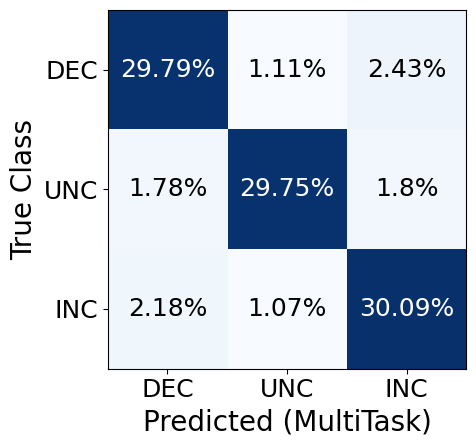

In [44]:
# Create confusion matrix for MultiTask vs. True labels
confusion_matrix_selfexplain = confusion_matrix(df_eval_mt["class"], df_eval_mt["class_mt"])
display_confusion_matrix(confusion_matrix_selfexplain, ylabel="True Class", xlabel="Predicted (MultiTask)")

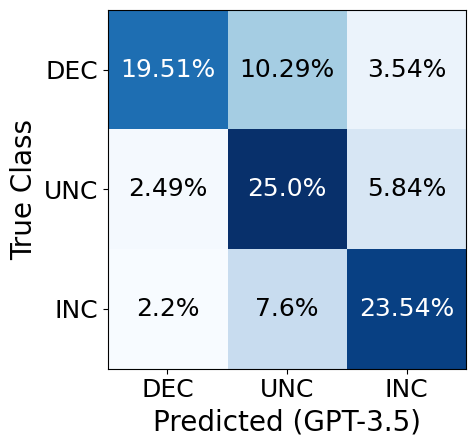

In [45]:
# Create confusion matrix for ChatGPT vs. True labels
confusion_matrix_gpt = confusion_matrix(df_eval["change"].map(class_mapping), df_eval_gpt["class"])
display_confusion_matrix(confusion_matrix_gpt, ylabel="True Class", xlabel="Predicted (GPT-3.5)")

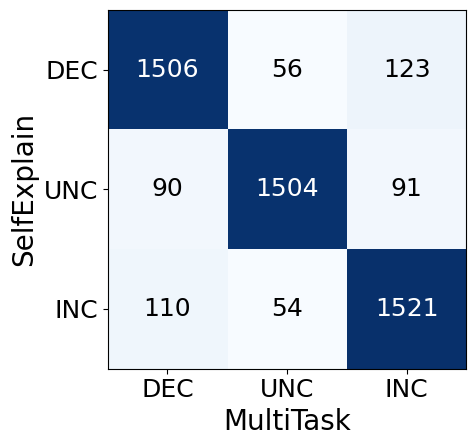

In [46]:
# Create confusion matrix for SelfExplain vs. MultiTask
confusion_matrix_multitask_change = confusion_matrix(df_eval_se["class"], df_eval_mt["class_mt"])
display_confusion_matrix(confusion_matrix_multitask_change, ylabel="SelfExplain", xlabel="MultiTask", withpercent=False)

# 3. Explanation Analysis
We look at the explanations provided by MultiTask and ChatGPT for random items that both classifiers classified either correctly or incorrectly. We also identify if most explanations in MultiTask stem from the target- or the follow-up statement.

In [160]:
# Join MT/SE dataframe with GPT dataframe on follow-up statement (GPT context = MT/SE follow_up)
# Rename gpt context to follow_up
df_eval_gpt.rename(columns={"context": "follow_up"}, inplace=True)
df_eval_mt = df_eval_mt.merge(df_eval_gpt[["follow_up", "explanation", "class"]], on="follow_up", suffixes=("_multi", "_gpt"))
df_eval_mt.rename(columns={"class_multi": "class"}, inplace=True)

df_eval_se = df_eval_se.merge(df_eval_gpt[["follow_up", "explanation", "class"]], on="follow_up", suffixes=("_self", "_gpt"))
df_eval_se.rename(columns={"class_self": "class"}, inplace=True)

In [161]:
df_eval_se.columns

Index(['target', 'follow_up', 'change', 'class', 'class_se', 'explanation_se',
       'explanation', 'class_gpt'],
      dtype='object')

In [162]:
both_classified_wrong = (df_eval_mt["class_mt"] != df_eval_mt["class"]) & (df_eval_mt["class_gpt"] != df_eval_mt["class"])
both_classified_correct = (df_eval_mt["class_mt"] == df_eval_mt["class"]) & (df_eval_mt["class_gpt"] == df_eval_mt["class"])

In [163]:
# Randomly sample 3 statements from the incorrect classifications
for idx in np.random.choice(np.where(both_classified_wrong)[0], 3):
    print(f"=====Statement {idx}=====")
    display_sample_statement(df_eval_mt, idx, "mt")
    print()

=====Statement 3144=====
Statement: I want to go out and do things, but my heart is pounding, and all I want to do is lie in bed; I think I'm just going to tell my boss I'm not feeling very well today so I won't be in.
True class: 2
Finetuned class: 0
ChatGPT class: 1
Finetuned explanation: I think I'm just going to tell my boss
ChatGPT explanation: The target statement indicates the author's current state of mind and desire to stay in bed. This suggests a short-term situation, likely lasting less than a day. For this reason, the most fitting label is 1-3 days. The context statement reveals the author's intention to call in sick to work, indicating that the author's current state of mind will likely persist for the entire day. As a result, the most fitting label is still 1-3 days. Since the information in the context statement does not change the temporal validity duration of the target statement, the final label is `unchanged`.

=====Statement 3572=====
Statement: tuning in to the new

In [164]:
# Randomly sample 3 statements from the correct classifications
for idx in np.random.choice(np.where(both_classified_correct)[0], 3):
    print(f"=====Statement {idx}=====")
    display_sample_statement(df_eval_mt, idx, "mt")
    print()

=====Statement 11=====
Statement: Just realizing I have a meeting 10 has already ruined my morning.; This meeting is also going to straight up kill my mood since I'm going to have to listen to my boss ramble for hours and hours.
True class: 2
Finetuned class: 2
ChatGPT class: 2
Finetuned explanation:  I'm going to have to listen to my boss ramble for hours and
ChatGPT explanation: The target statement indicates that the author's morning has been negatively impacted by the realization of a meeting at 10. This suggests that the effect is ongoing and likely to last for a significant portion of the morning. Therefore, the most fitting label is 2-6 hours. The context statement further emphasizes the negative impact of the meeting, indicating that it will last for "hours and hours." This suggests that the negative impact will extend beyond the morning and likely last for a longer duration. As a result, the most fitting label is More than 6 hours. As the information in the context statement i

In [165]:
# Find the fraction of Multitask explanations that are part of the follow-up statement (i.e., occur after </s>)
num_target = 0
num_followup = 0
num_unclear = 0

for idx in range(len(df_eval_mt)):
    target = df_eval_mt.iloc[idx]["target"]
    follow_up = df_eval_mt.iloc[idx]["follow_up"]
    explanation = df_eval_mt.iloc[idx]["explanation_mt"]

    if explanation in follow_up and explanation not in target:
        num_followup += 1
    elif explanation in target and explanation not in follow_up:
        num_target += 1
    else:
        num_unclear += 1

print(f"Fraction of explanations that are part of the target: {num_target / len(df_eval)}")
print(f"Fraction of explanations that are part of the follow-up statement: {num_followup / len(df_eval)}")
print(f"Fraction of explanations that are part of either statement: {num_unclear / len(df_eval)}")

Fraction of explanations that are part of the target: 0.3149357072205737
Fraction of explanations that are part of the follow-up statement: 0.6490603363006924
Fraction of explanations that are part of either statement: 0.03639960435212661


# 4. Impact of Change Delta on Performance
We evaluate whether the change delta (class distance between original and updated expected temporal validity duration) has an impact on classifier performance.

In [166]:
# Define delta groups
delta_0_mt = df_eval_mt[df_eval_mt["change"].abs() == 0]
delta_1_mt = df_eval_mt[df_eval_mt["change"].abs() == 1]
delta_2_mt = df_eval_mt[df_eval_mt["change"].abs() == 2]
delta_gt2_mt = df_eval_mt[df_eval_mt["change"].abs() > 2]

delta_0_se = df_eval_se[df_eval_se["change"].abs() == 0]
delta_1_se = df_eval_se[df_eval_se["change"].abs() == 1]
delta_2_se = df_eval_se[df_eval_se["change"].abs() == 2]
delta_gt2_se = df_eval_se[df_eval_se["change"].abs() > 2]

In [167]:
# Calculate accuracy for each delta
se_accs = [sum(delta_0_se["class"] == delta_0_se["class_se"]) / len(delta_0_se), sum(delta_1_se["class"] == delta_1_se["class_se"]) / len(delta_1_se), sum(delta_2_se["class"] == delta_2_se["class_se"]) / len(delta_2_se), sum(delta_gt2_se["class"] == delta_gt2_se["class_se"]) / len(delta_gt2_se)]
mt_accs = [sum(delta_0_mt["class"] == delta_0_mt["class_mt"]) / len(delta_0_mt), sum(delta_1_mt["class"] == delta_1_mt["class_mt"]) / len(delta_1_mt), sum(delta_2_mt["class"] == delta_2_mt["class_mt"]) / len(delta_2_mt), sum(delta_gt2_mt["class"] == delta_gt2_mt["class_mt"]) / len(delta_gt2_mt)]
gpt_accs = [sum(delta_0_mt["class"] == delta_0_mt["class_gpt"]) / len(delta_0_mt), sum(delta_1_mt["class"] == delta_1_mt["class_gpt"]) / len(delta_1_mt), sum(delta_2_mt["class"] == delta_2_mt["class_gpt"]) / len(delta_2_mt), sum(delta_gt2_mt["class"] == delta_gt2_mt["class_gpt"]) / len(delta_gt2_mt)]

In [208]:
# Plot the accuracy for each delta using plotly
fig = go.Figure()
#fig.add_trace(go.Scatter(x=[0,1,2,3], y=se_accs, name="SelfExplain", mode="lines"))
fig.add_trace(go.Scatter(x=[0,1,2,3], y=mt_accs, name="MultiTask", mode="lines"))
fig.add_trace(go.Scatter(x=[0,1,2,3], y=gpt_accs, name="GPT-3.5-turbo", mode="lines"))
fig.update_layout(barmode='group', xaxis_title="Change Delta", yaxis_title="Accuracy",
                  xaxis=dict(
                      tickmode='array',
                      tickvals=[0,1,2,3],
                      ticktext=["0", "1", "2", ">2"]
                  ),
                  template="plotly_white",
                  width=800,
                  height=300)
fig.update_layout(
    font=dict(
        size=18
    )
)
fig.update_traces(line=dict(width=4))
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
fig.show()

## 5. Significance Evaluation

In [169]:
df_eval_mt.sort_values(by="target", inplace=True)
df_eval_se.sort_values(by="target", inplace=True)

In [170]:
results_selfexplain_acc = sum(df_eval_se["class"] == df_eval_se["class_se"]) / len(df_eval)
results_multitask_acc = sum(df_eval_mt["class"] == df_eval_mt["class_mt"]) / len(df_eval)

print(f"SelfExplain Accuracy: {results_selfexplain_acc}")
print(f"MultiTask Accuracy: {results_multitask_acc}")

SelfExplain Accuracy: 0.885459940652819
MultiTask Accuracy: 0.8967359050445104


In [171]:
results_selfexplain_em = calculate_em(df_eval_se["class"], df_eval_se["class_se"])
results_multitask_em = calculate_em(df_eval_mt["class"], df_eval_mt["class_mt"])

print(f"SelfExplain EM: {results_selfexplain_em}")
print(f"MultiTask EM: {results_multitask_em}")

SelfExplain EM: 0.701067615658363
MultiTask EM: 0.7212336892052195


In [172]:
# Bootstrap Test: Accuracy
p_value, conf_interval = bootstrap(df_eval_se["class_se"], df_eval_mt["class_mt"], df_eval_mt["class"])
print(f"p-value: {p_value}")
print(f"Confidence Interval: {conf_interval}")

100%|██████████| 10000/10000 [07:16<00:00, 22.90it/s]

p-value: 0.0012
Confidence Interval: (0.0035594225825588293, 0.019181332806011468)


In [203]:
# Bootstrap Test: EM
ems_se = calculate_em(df_eval_se["class"], df_eval_se["class_se"], return_labels=True)
ems_mt = calculate_em(df_eval_mt["class"], df_eval_mt["class_mt"], return_labels=True)
ems_true = pd.Series([1] * len(ems_se))
p_value, conf_interval = bootstrap(ems_se, ems_mt, ems_true)

print(f"p-value: {p_value}")
print(f"Confidence Interval: {conf_interval}")

100%|██████████| 10000/10000 [00:49<00:00, 202.00it/s]

p-value: 0.0216
Confidence Interval: (0.0005931198102016608, 0.039739027283511266)


# 6. Data Impact on Performance

In [30]:
# Load a tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [39]:
classifiers = []
set_up_deterministic_environment(RANDOM_SEED)
for frac in [0.25, 0.5, 0.75, 1]:
    embedding_model = RobertaModel.from_pretrained('roberta-base')
    # Load the training, validation, and test sets
    train_set = TwitterDataset(TRAIN_SET_PATH, tokenizer, output_columns={"change":"labels", "context_only_tv": "labels_duration_standalone", "combined_tv": "labels_duration_combined"}, scale_columns={"labels_duration_standalone": (0,11), "labels_duration_combined": (0,11)})
    val_set = TwitterDataset(VAL_SET_PATH, tokenizer, output_columns={"change":"labels", "context_only_tv": "labels_duration_standalone", "combined_tv": "labels_duration_combined"}, scale_columns={"labels_duration_standalone": (0,11), "labels_duration_combined": (0,11)})
    test_set = TwitterDataset(TEST_SET_PATH, tokenizer, output_columns={"change":"labels", "context_only_tv": "labels_duration_standalone", "combined_tv": "labels_duration_combined"}, scale_columns={"labels_duration_standalone": (0,11), "labels_duration_combined": (0,11)})
    fold_name=f"fraction-{frac}"
    # Only take a fraction of the training set
    if frac < 1:
        train_indices, _ = stratified_target_statement_split(train_set.get_target_statements(), val_fraction=(1-frac))
        train_set = Subset(train_set, train_indices)
    # Train and evaluate model
    cls = ExplainableModel(embedding_model, freeze_embedding_model=False, multitask=True, multitask_multiplier=20).to(device)

    best_model, train_losses, val_losses, accs, ems = train_loop(cls, train_set=train_set, val_set=val_set, collate_fn=partial(self_explain_collate_batch, input_padding=1), device=device, batch_size=BATCH_SIZE,max_epochs=MAX_EPOCHS, lr=LR, patience=5, name=fold_name)

    test_loss, acc, em = eval_loop(best_model, test_set, partial(self_explain_collate_batch, input_padding=1), device, batch_size=BATCH_SIZE)

    # Append results to list
    classifiers.append((fold_name, train_losses, val_losses, accs, ems, test_loss, acc, em))

Epoch Report: Epoch 9/30, Model fraction-1
- Train loss: 0.0651
- Val loss: 0.8878
- Acc: 0.9008
- EM: 0.7560
Optimizing for EM, current best: 0.7619 (No improvement for 4 epochs)


Validating fraction-1, Epoch 10/30: 100%|==========| 32/32 [00:01<00:00, 26.52it/s]


Early stopping.


Testing: 100%|==========| 32/32 [00:01<00:00, 29.30it/s]

Test Loss: 0.7907774839550257
Accuracy: 0.9246031746031746
EM: 0.7857142857142857


In [40]:
# Store results
with open(SEMANTIC_EVAL_PATH.format("dataimpact.pkl"), 'wb') as f:
    pickle.dump(classifiers, f)

In [174]:
# Load results
with open(SEMANTIC_EVAL_PATH.format("dataimpact.pkl"), 'rb') as f:
    classifiers = pickle.load(f)

In [175]:
# Plot number of epochs until convergence using Plotly
fig = go.Figure()
num_epochs = list(map(lambda x: x[4].index(max(x[4])), classifiers))

fig.add_trace(go.Scatter(x=[0.25,0.5,0.75,1], y=num_epochs, name="SelfExplain", mode="lines"))

fig.update_layout(barmode='group', xaxis_title="Fraction of Training Data", yaxis_title="Number of Epochs",
                  xaxis=dict(
                      tickmode='array',
                      tickvals=[0.25,0.5,0.75,1],
                      ticktext=["25%", "50%", "75%", "100%"]
                  ),
                  template="plotly_white",
                  width=800,
                  height=300)
fig.update_layout(
    font=dict(
        size=18
    )
)
fig.update_traces(line=dict(width=4))
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
fig.show()

In [176]:
# Plot accuracy and EM using Plotly
fig = go.Figure()
accs = list(map(lambda x: x[6], classifiers))
ems = list(map(lambda x: x[7], classifiers))

fig.add_trace(go.Scatter(x=[0.25,0.5,0.75,1], y=accs, name="Accuracy", mode="lines"))
fig.add_trace(go.Scatter(x=[0.25,0.5,0.75,1], y=ems, name="EM", mode="lines"))

fig.update_layout(barmode='group', xaxis_title="Fraction of Training Data", yaxis_title="Accuracy/EM",
                  xaxis=dict(
                      tickmode='array',
                      tickvals=[0.25,0.5,0.75,1],
                      ticktext=["25%", "50%", "75%", "100%"]
                  ),
                  template="plotly_white",
                  width=800,
                  height=300)
fig.update_layout(
    font=dict(
        size=18
    )
)
fig.update_traces(line=dict(width=4))
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
fig.show()

# 7. LLM Rejection Rate
We plot the "rejection rate" of the LLM, i.e., the fraction of statements for which the LLM does not provide one of the defined classes in its explanation. This is indicated by the fraction of statements for which the class label is set to -1.

In [180]:
# Get all LLM DFs
df_eval_gpt = pd.read_csv(LLM_DATA_PATH.format("GPT3-5.csv"))
df_eval_gpt4 = pd.read_csv(LLM_DATA_PATH.format("GPT4.csv"))
df_eval_llama2 = pd.read_csv(LLM_DATA_PATH.format("Llama2.csv"))
df_eval_mixtral = pd.read_csv(LLM_DATA_PATH.format("Mixtral.csv"))

In [189]:
# Calculate rejection rates
rejection_rates = [sum(df_eval_gpt["class"] == -1) / len(df_eval_gpt), sum(df_eval_gpt4["class"] == -1) / len(df_eval_gpt4), sum(df_eval_llama2["class"] == -1) / len(df_eval_llama2), sum(df_eval_mixtral["class"] == -1) / len(df_eval_mixtral)]
rejection_rates = [round(r * 100, 2) for r in rejection_rates]

In [205]:
# Plot rejection rates using Plotly as bar chart
fig = go.Figure()
fig.add_trace(go.Bar(x=["GPT-3.5-turbo", "GPT-4", "Llama2", "Mixtral"], y=rejection_rates, name="Rejection Rate"))
fig.update_layout(barmode='group', xaxis_title="Large Language Model", yaxis_title="No Answer Given (%)",
                  template="plotly_white",
                  width=800,
                  height=300)
fig.update_layout(
    font=dict(
        size=18
    )
)
fig.show()